In [93]:
import os
import sys
import time
import glob
import hdf5_getters as GETTERS
import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
path = os.getcwd()
msd_path = os.path.join(path, 'MillionSongSubset')
msd_data_path = os.path.join(msd_path,'data')
msd_user_path = os.path.join(msd_path, 'user')
msd_addf_path = os.path.join(msd_path, 'AdditionalFiles')

### I. Year Imputation

In [6]:
data = pd.read_csv('subset_metadata.csv')
data = data.drop(['Unnamed: 0'], axis=1)

In [8]:
msd_user_file = os.path.join(msd_user_path, 'train_triplets.txt')
user_data = pd.read_csv(msd_user_file, sep='\t', header = None)
user_data = user_data.rename(columns = {0:'user_id', 1:'song_id', 2:'play_counts'})
unique_song_id = list(set(user_data['song_id']))

In [9]:
song_id_2 = list(set(unique_song_id) & set(data['song_id']))
user_subset = user_data.loc[(user_data['song_id'].isin(song_id_2))]

In [10]:
user_subset

,user_id,song_id,play_counts
90,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1
182,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODCXXY12AB0187452,2
197,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOWPAXV12A67ADA046,18
304,b64cdd1a0bd907e5e00b39e345194768e330d652,SOLXDDC12A6701FBFD,1
308,b64cdd1a0bd907e5e00b39e345194768e330d652,SONJBQX12A6D4F8382,4
...,...,...,...
48373364,8305c896f42308824da7d4386f4b9ee584281412,SOQHWMN12A6701E2D9,1
48373382,8305c896f42308824da7d4386f4b9ee584281412,SOSQIHH12A8C13370B,1
48373405,8305c896f42308824da7d4386f4b9ee584281412,SOUCKDH12A8C138FF5,2
48373415,8305c896f42308824da7d4386f4b9ee584281412,SOULTKQ12AB018A183,4


<AxesSubplot:ylabel='Frequency'>

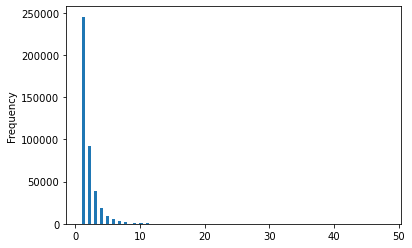

In [15]:
# user_playcounts = user_subset.groupby('user_id').sum('play_counts').sort_values(by = 'play_counts')
user_subset.groupby('user_id').count()['song_id'].plot(kind='hist', bins=100)

In [19]:
len(set(user_subset['user_id']))

418252

In [23]:
user_song = user_subset.groupby('user_id').count()
user_song = user_song[user_song['song_id'] >= 5]

In [35]:
user_id = list(user_song.index)
user_subset = user_subset.loc[(user_subset['user_id'].isin(user_id))]

In [55]:
user_subset.groupby('user_id').sum('play_counts').sort_values('play_counts', ascending=False)

,play_counts
user_id,
2e66a7d40cfef39d68113ab429217176e11a4c42,365
5d5a27d2fe3d45e515e79ddb7f70822ef5cd3600,320
095d3cdd061c5bb043d94a19f5dea5d96e215c9d,290
7816cb2b56365299a6ad4a6ea437d005c0776d2a,250
484734ce6667a6a25df23a961d5c5a9458afbfa1,232
...,...
13926f96e54793cc4c0bbb2b49b2665406f3baf9,5
bd996c09f5985bfeae6cb7eb294789818de244c5,5
71dcb6345592bcc8dbb7aa7d4b5adafc49c1be65,5


In [54]:
user_subset.groupby('song_id').sum('play_counts').sort_values('play_counts', ascending=False)

,play_counts
song_id,
SOIZLKI12A6D4F7B61,11905
SOULTKQ12AB018A183,8907
SOEKSGJ12A67AE227E,5895
SOEHWGF12A6D4F8B2B,5562
SOUCKDH12A8C138FF5,5406
...,...
SOWISQE12A6D4F7DBB,1
SOAULBO12A58A7A2F8,1
SOCXRVU12A6D4F87A2,1


In [59]:
user_subset.to_csv('user_subset.csv')

In [149]:
def apply_to_h5(basedir,func=lambda x: x,ext='.h5'):

    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
        for f in files :
            func(f)       
    return cnt

In [178]:
feature_names = ['song_id','title','song_hotness','duration','key','loudness','mode','tempo','artist','artist_hotness']
song_id,title=[],[]
song_hotness,duration,key=[],[],[]
loudness,mode,tempo,artist,artist_hotness=[],[],[],[],[]

def get_attr(filepath):
    h5 = GETTERS.open_h5_file_read(filepath)
    song_id.append(GETTERS.get_song_id(h5).decode('utf-8'))
    title.append(GETTERS.get_title(h5).decode('utf-8'))
    song_hotness.append(GETTERS.get_song_hotttnesss(h5))
    duration.append(GETTERS.get_duration(h5))
    key.append(GETTERS.get_key(h5))
    loudness.append(GETTERS.get_loudness(h5))
    mode.append(GETTERS.get_mode(h5))
    tempo.append(GETTERS.get_tempo(h5))
    artist.append(GETTERS.get_artist_name(h5).decode('utf-8'))
    artist_hotness.append(GETTERS.get_artist_hotttnesss(h5))
    h5.close()     

In [179]:
print ('number of song files:',apply_to_h5(msd_data_path))

number of song files: 10000


In [180]:
t1 = time.time()
apply_to_h5(msd_data_path, get_attr)
t2 = time.time()
# print (strtimedelta(t1,t2))

0:03:14.032456


In [185]:
meta_data = pd.DataFrame(song_id, columns=['song_id'])
meta_data['title'] = title
meta_data['song_hotness'] = song_hotness
meta_data['duration'] = duration
meta_data['key'] = key
meta_data['loudness'] = loudness
meta_data['mode'] = mode
meta_data['tempo'] = tempo
meta_data['artist'] = artist
meta_data['artist_hotness'] = artist_hotness

In [188]:
meta_data.to_csv('meta_data_subset.csv')